# Differential rotation with `starry`

In this notebook, we'll explain how to express the radial velocity field of a star at an arbitrary orientation on the sky in terms of spherical harmonics. This allows us to use `starry` to model the Rossiter-McLaughlin waveform **analytically**!

First, let's import some stuff. We'll use `sympy` for the derivations.

In [1]:
import matplotlib.pyplot as pl
%matplotlib notebook
import numpy as np
from IPython.display import display, Math
import sympy
from sympy import *
from sympy.functions.special.tensor_functions import KroneckerDelta
print("Using sympy version", sympy.__version__)

# Initialize the session
init_session(quiet=True)

# Define our symbols
x, y, z, mu, nu, l, m, j, k, p, q, n, A, B, C, alpha, omeq = symbols('x y z mu nu l m j k p q n A B C alpha \omega_{eq}')

Using sympy version 1.3



## The radial velocity field of a star

The polynomial describing the radial component of the velocity field on the projected disk of a star is given by ([Short et al. 2018](https://arxiv.org/abs/1810.09565))

$f(\mathbf{x}, \mathbf{y}, \mathbf{z}) = \omega_{eq}(A\mathbf{x} + B\mathbf{y})(1 - \alpha(-B\mathbf{x} + A\mathbf{y} + C\mathbf{z})^2)$

where 

$A = \sin(i)\cos(\lambda)$

$B = \sin(i)\sin(\lambda)$

$C = \cos(i)$

and $i$ and $\lambda$ are the stellar inclination and obliquity, respectively. The constant $\alpha$ is the shear due to differential rotation. We are assuming a simple linear shear according to the following equation:

$\omega = \omega_{eq}(1 - \alpha \sin^2\theta)$,

where $\omega$ is the angular rotational velocity at a point on the surface, $\omega_{eq}$ is the velocity at the equator, and $\theta$ is the polar angle (latitude).

## Let's expand this function

If we expand all the products in $f$, we can write it as a dot product of a polynomial coefficient vector and the polynomial basis defined in Luger et al. (2018):

In [2]:
def poly_basis(n, x, y):
    """Return the n^th term in the polynomial basis."""
    l = Rational(floor(sqrt(n)))
    m = Rational(n - l * l - l)
    mu = Rational(l - m)
    nu = Rational(l + m)
    if (nu % 2 == 0):
        i = Rational(mu, 2)
        j = Rational(nu, 2)
        k = Rational(0)
    else:
        i = Rational(mu - 1, 2)
        j = Rational(nu - 1, 2)
        k = Rational(1)
    return x ** i * y ** j * sqrt(1 - x ** 2 - y ** 2) ** k

# Compute the polynomial basis
basis = Matrix([poly_basis(n, x, y) for n in range(16)]).T

Here's what the polynomial basis looks like (recall that $z = \sqrt{1 - x^2 - y^2}$):

In [3]:
basis

And here's the function we wish to express:

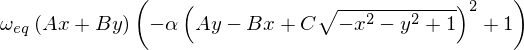

In [4]:
f = omeq * (A * x + B * y) * (1 - alpha * (-B * x + A * y + C * sqrt(1 - x ** 2 - y ** 2)) ** 2)
f

We can use `sympy` to figure out the (exact) representation of `f` in the polynomial basis:

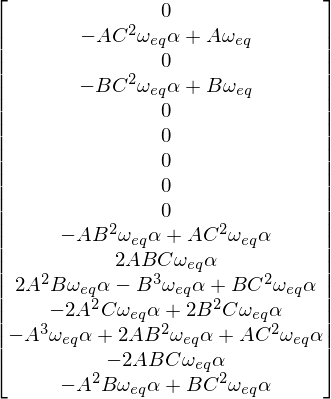

In [5]:
def Coefficient(expression, term):
    """Return the coefficient multiplying `term` in `expression`."""
    # Get the coefficient
    coeff = expression.coeff(term)
    # Set any non-constants in this coefficient to zero. If the coefficient
    # is not a constant, this is not the term we are interested in!
    coeff = coeff.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)
    return coeff

vec = Matrix([Coefficient(expand(f), term) for term in basis])
vec

We can check that dotting this vector with the polynomial basis yields the original function $f$:

In [6]:
simplify(factor(basis.dot(vec)) - f) == 0

True

## Now let's represent it in terms of spherical harmonics

Now that we have the vector of polynomial coefficients `vec`, we want to apply a change-of-basis transformation to figure out their (exact) representation in terms of spherical harmonics.

As in Luger et al. (2018), let's compute the change of basis matrix from polynomials to spherical harmonic coefficients. This is the inverse of the $A_1$ matrix introduced in Luger et al. (2018). Note that it includes the normalization of $\frac{2}{\sqrt{\pi}}$ used internally by `starry`.

In [7]:
def SA(l, m):
    """A spherical harmonic normalization constant."""
    return sqrt((2 - KroneckerDelta(m, 0)) * (2 * l + 1) * factorial(l - m) / (4 * pi * factorial(l + m)))

def SB(l, m, j, k):
    """Another spherical harmonic normalization constant."""
    try: 
        ratio = factorial(Rational(l + m + k - 1, 2)) / factorial(Rational(-l + m + k - 1,  2))
    except ValueError:
        ratio = 0
    res = 2 ** l * Rational(factorial(m), (factorial(j) * factorial(k) * factorial(m - j) * factorial(l - m - k))) * ratio
    return simplify(res)

def SC(p, q, k):
    """Return the binomial theorem coefficient `C`."""
    res = factorial(Rational(k, 2)) / (factorial(Rational(q, 2)) * factorial(Rational(k - p, 2)) * factorial(Rational(p - q, 2)))
    return simplify(res)

def Y(l, m, x, y):
    """Return the spherical harmonic of degree `l` and order `m`."""
    res = 0
    z = sqrt(1 - x ** 2 - y ** 2)
    if (m >= 0):
        for j in range(0, m + 1, 2):
            for k in range(0, l - m + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p) // 2) * SA(l, m) * SB(l, m, j, k) * SC(p, q, k) * x ** (m - j + p - q) * y ** (j + q)
            for k in range(1, l - m + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p) // 2) * SA(l, m) * SB(l, m, j, k) * SC(p, q, k - 1) * x ** (m - j + p - q) * y ** (j + q) * z          
    else:
        for j in range(1, abs(m) + 1, 2):
            for k in range(0, l - abs(m) + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p - 1) // 2) * SA(l, abs(m)) * SB(l, abs(m), j, k) * SC(p, q, k) * x ** (abs(m) - j + p - q) * y ** (j + q)
            for k in range(1, l - abs(m) + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p - 1) // 2) * SA(l, abs(m)) * SB(l, abs(m), j, k) * SC(p, q, k - 1) * x ** (abs(m) - j + p - q) * y ** (j + q) * z

    return res

def p_Y(l, m, lmax):
    """Return the polynomial basis representation of the spherical harmonic `Y_{lm}`."""
    ylm = Y(l, m, x, y)
    res = [ylm.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)]
    for n in range(1, (lmax + 1) ** 2):
        res.append(Coefficient(ylm, poly_basis(n, x, y)))
    return res

def A1(lmax, norm = 2 / sqrt(pi)):
    """Return the change of basis matrix A1. The columns of this matrix are given by `p_Y`."""
    res = zeros((lmax + 1) ** 2, (lmax + 1) ** 2)
    n = 0
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            res[n] = p_Y(l, m, lmax)
            n += 1
    return res * norm

We can now evaluate the change of basis matrix from spherical harmonic coefficients to polynomials, $A_1$ for $l_\mathrm{max} = 3$. We then take the inverse to go from polynomial coeffiecients to $Y_{lm}$ coefficients:

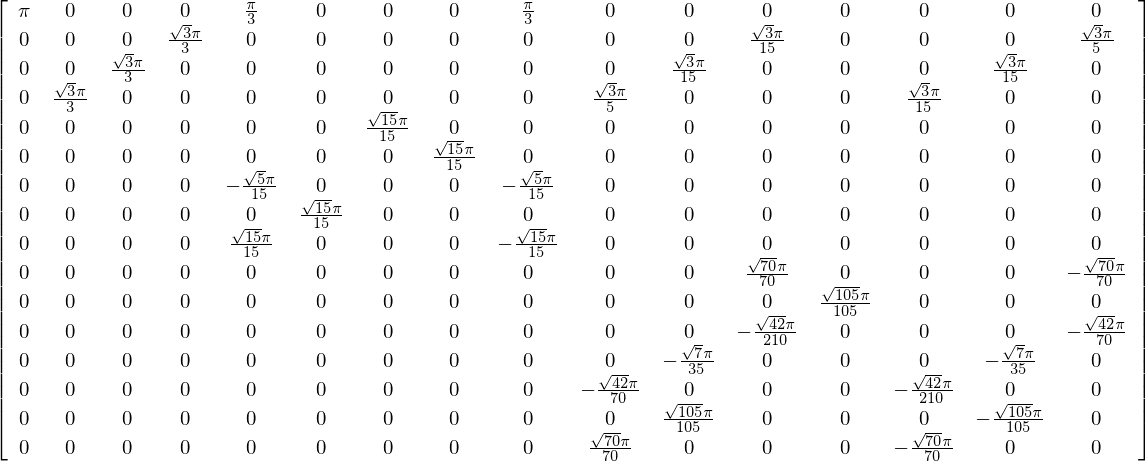

In [8]:
M = Matrix(A1(3)).inv()
M

## The end result

We can finally compute the spherical harmonic coefficients of the function $f$:

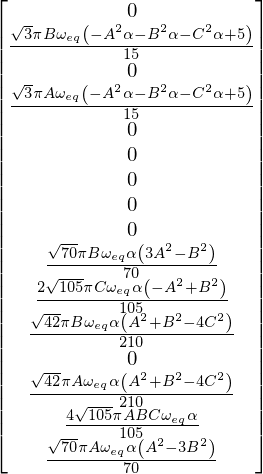

In [9]:
ycoeffs = simplify(M * vec)
ycoeffs

Note that this is the **exact** spherical harmonic representation of the function `f`.

## Interactive visualization

Below you can interactively see how different velocity profiles affect the Rossiter-McLaughlin waveform. We coded up a simple Jupyter widget to visualize the RM effect with `starry`. Try to find the parameters that best fit the measured RV data for the hot jupiter host HD 189733!

In [3]:
from viz import visualize
visualize();

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='$v_\\mathrm{eq}$ [km / s]:'…

## One possible solution

The following values should get you a pretty good fit. They are close to the means of the posterior distributions when we do a full MCMC fit of the dataset, but they are probably not the "true" values.

$v_{eq}$: 5.00

$\lambda$: -0.50

$i$: 80.0

$\alpha$: 0.65

$u_1$: 1.50

$u_2$: -0.54

$b$: -0.66

$r/R_\star$: 0.158